In [40]:
import argparse, sys, shutil, glob, os
from pathlib import Path
from itertools import combinations
from datetime import datetime

import numpy as np
import pandas as pd
import arviz as az
# from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.special import expit, logit
from tqdm import tqdm
import pickle
# import pystan
# import stan


# 1) Load your saved .nc

In [41]:
import arviz as az
from pathlib import Path

nc_path = "stan_out/rlddm_single_subject-20250924_184320.nc"  # <- your file
idata = az.from_netcdf(nc_path)


# 2) Quick sanity: R-hat / ESS

In [42]:
az.summary(idata, var_names=["alpha","a","t0","scaler", "log_scaler"], hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.309,0.119,0.093,0.542,0.002,0.003,2599.0,1760.0,1.0
a,1.272,0.030,1.215,1.332,0.001,0.001,2824.0,2281.0,1.0
t0,0.313,0.005,0.304,0.323,0.000,0.000,2603.0,1925.0,1.0
scaler,0.047,0.011,0.028,0.070,0.000,0.000,2631.0,2525.0,1.0
log_scaler,-3.077,0.230,-3.511,-2.618,0.004,0.004,2631.0,2525.0,1.0


# 3) Correlations among parameters (all draws)

In [43]:
post = az.extract(idata, var_names=["alpha","a","t0","scaler", "log_scaler"], combined=True).to_pandas()
post.corr()


,alpha,a,t0,scaler,log_scaler,chain,draw
alpha,1.000000,0.332357,-0.083072,-0.395552,-0.394961,-1.179381e-02,-1.589220e-03
a,0.332357,1.000000,-0.395485,0.170772,0.173961,-1.575336e-02,-1.157623e-02
t0,-0.083072,-0.395485,1.000000,-0.069212,-0.072063,-8.006387e-03,-1.725023e-02
scaler,-0.395552,0.170772,-0.069212,1.000000,0.987949,-6.774170e-03,-1.405982e-02
log_scaler,-0.394961,0.173961,-0.072063,0.987949,1.000000,-8.428665e-03,-1.488238e-02
chain,-0.011794,-0.015753,-0.008006,-0.006774,-0.008429,1.000000e+00,-1.756362e-16
draw,-0.001589,-0.011576,-0.017250,-0.014060,-0.014882,-1.756362e-16,1.000000e+00


# 4) Correlations with divergent draws removed

In [44]:
# boolean mask of divergent transitions aligned to combined draws
div = idata.sample_stats["diverging"].stack(sample=("chain","draw")).values.astype(bool)
post_ok = post[~div]
post_ok.corr()


,alpha,a,t0,scaler,log_scaler,chain,draw
alpha,1.000000,0.343600,-0.090873,-0.407371,-0.408475,-0.011675,-0.003427
a,0.343600,1.000000,-0.395761,0.179076,0.182806,-0.005921,-0.008920
t0,-0.090873,-0.395761,1.000000,-0.067940,-0.071102,-0.012648,-0.016884
scaler,-0.407371,0.179076,-0.067940,1.000000,0.988151,-0.011639,-0.014399
log_scaler,-0.408475,0.182806,-0.071102,0.988151,1.000000,-0.013391,-0.014993
chain,-0.011675,-0.005921,-0.012648,-0.011639,-0.013391,1.000000,-0.004732
draw,-0.003427,-0.008920,-0.016884,-0.014399,-0.014993,-0.004732,1.000000


# 5) Helpful plots (optional)

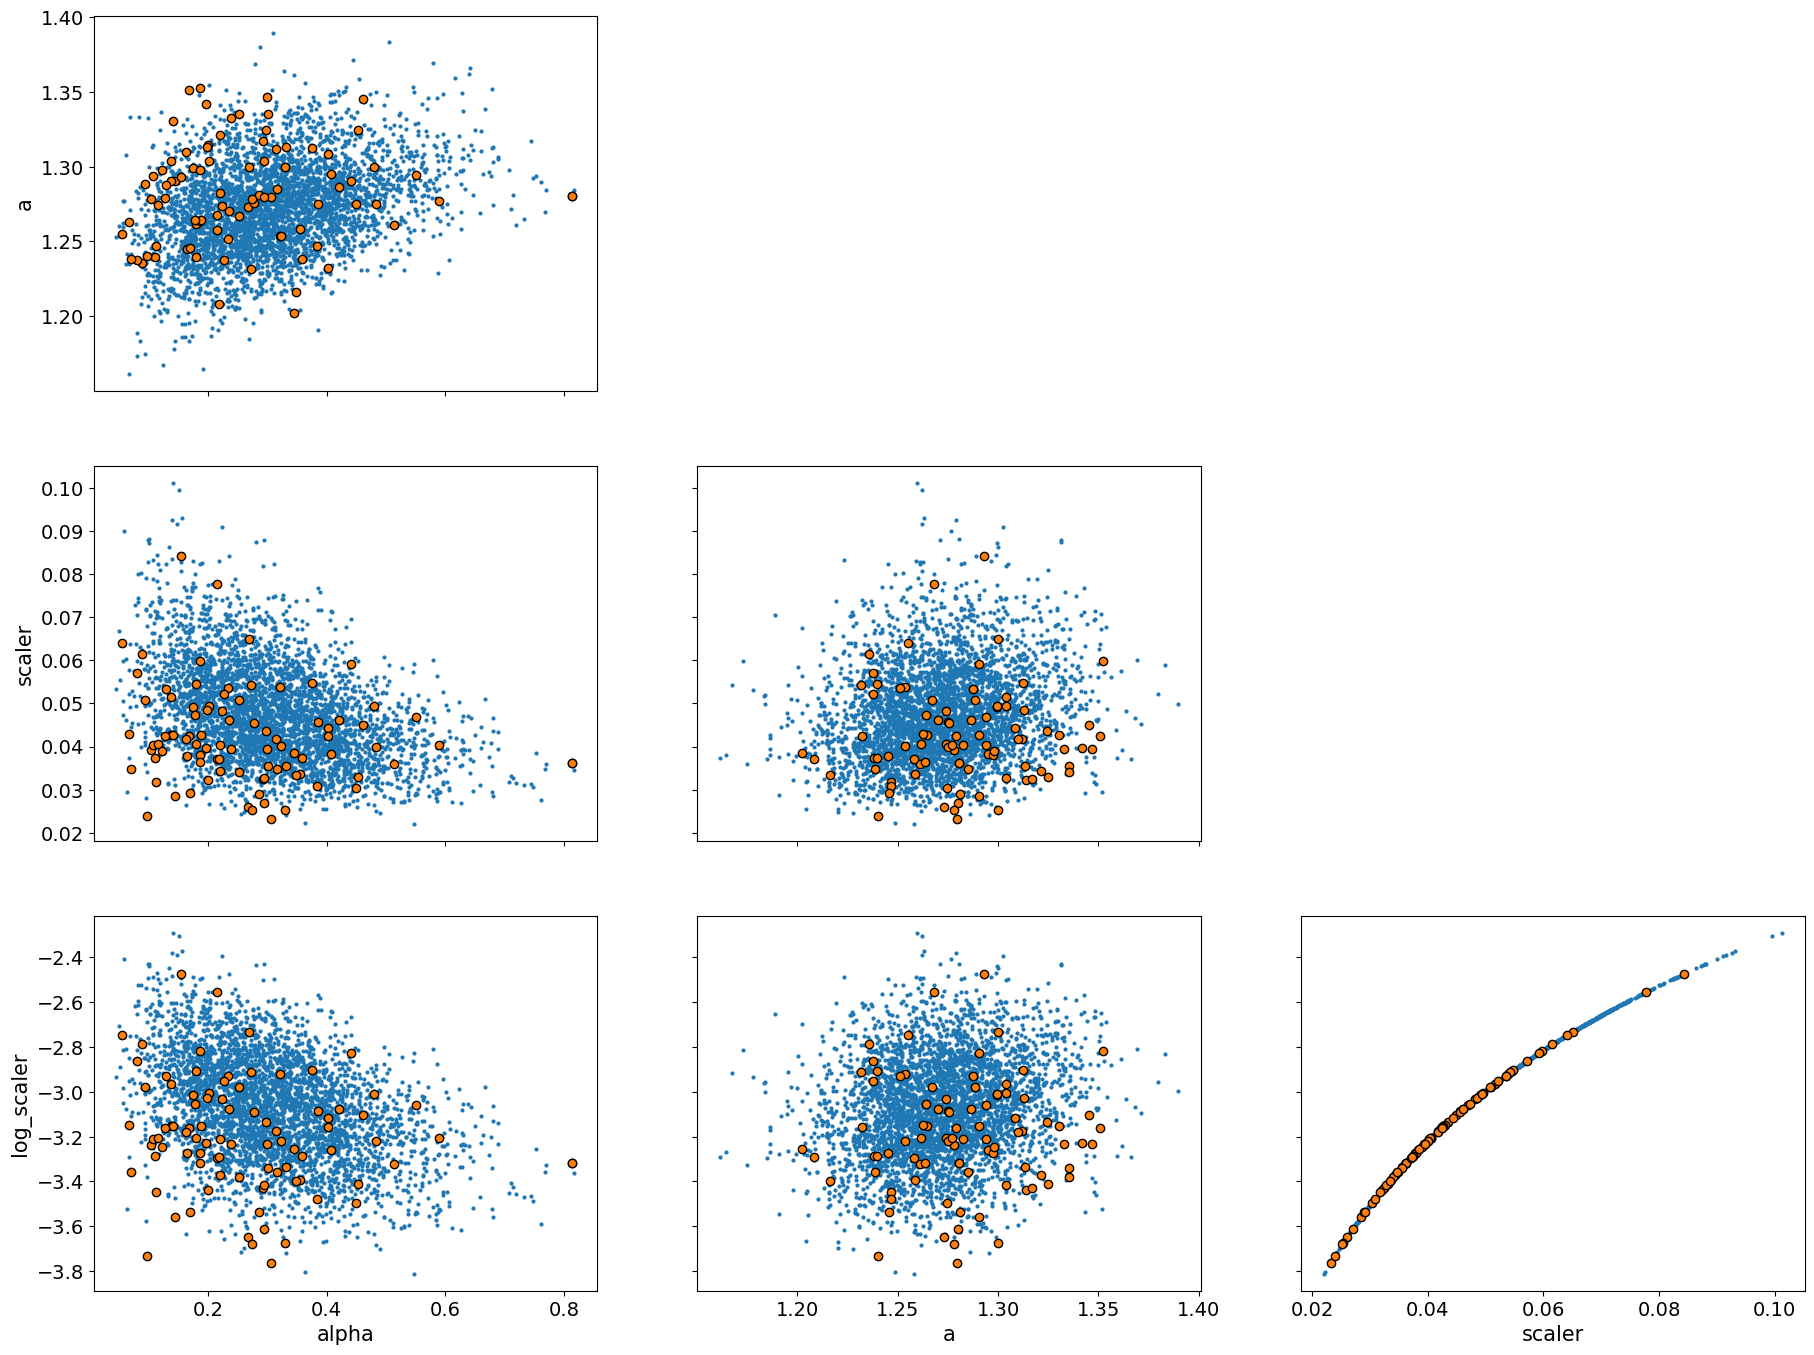

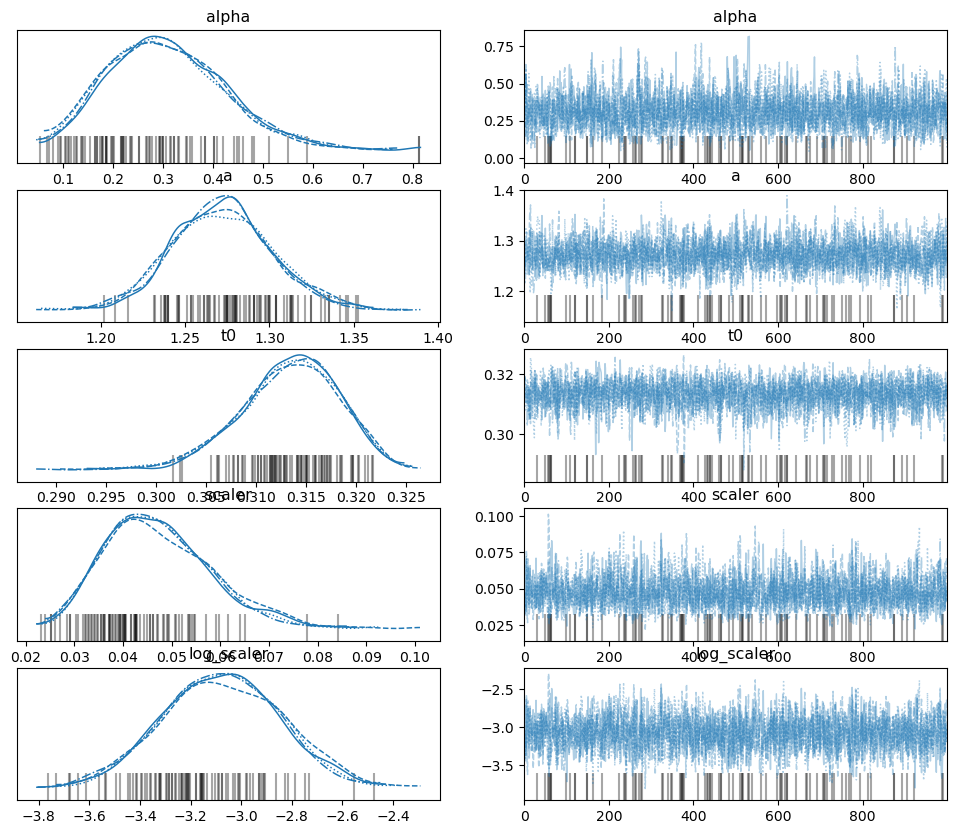

In [45]:
az.plot_pair(idata, var_names=["alpha","a","scaler", "log_scaler"], kind="scatter", divergences=True);
az.plot_trace(idata, var_names=["alpha","a","t0","scaler", "log_scaler"]);

# 6) Count divergences, max treedepth, etc.

In [46]:
print(int(idata.sample_stats["diverging"].sum()),
int((idata.sample_stats["tree_depth"] == idata.sample_stats["tree_depth"].max()).sum()))


89 387
